In [1]:
import nibabel as nib
from totalsegmentator.python_api import totalsegmentator
import os
import SimpleITK as sitk
import tqdm.notebook

In [ ]:
def convert_series_to_nifti(input_directory, output_file):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(input_directory)
    reader.SetFileNames(dicom_names)
    image_series = reader.Execute()
    
    # Convert to numpy array to manipulate the pixel data directly
    img_array = sitk.GetArrayFromImage(image_series)
        
    # Convert the numpy array back to a SimpleITK Image
    processed_image = sitk.GetImageFromArray(img_array)
    processed_image.SetSpacing(image_series.GetSpacing())
    processed_image.SetOrigin(image_series.GetOrigin())
    processed_image.SetDirection(image_series.GetDirection())

    # Write the processed image as a NIfTI file
    sitk.WriteImage(processed_image, output_file)

In [ ]:
output_dir = r'D:\CTH_archive\CTP_NIFTI'
os.makedirs(output_dir, exist_ok=True)

for patient in tqdm(os.listdir(r'D:\CTH_archive\CTP_DICOM')):
    for file in os.listdir(os.path.join(r'D:\CTH_archive\CTP_DICOM', patient)):
        input_directory = os.path.join(r'D:\CTH_archive\CTP_DICOM', patient , file)
        output_file = os.path.join(output_dir, str(patient) + '.nii.gz')            
        convert_series_to_nifti(input_directory, output_file)
        print(f'Converted {input_directory} to {output_file}')

In [ ]:
# Preform Skull Stripping
input_folder = 'D:\\CTH_archive\\CTP_NIFTI'
output_folder = 'D:\\CTH_archive\\CTP_Segmented_NIFTI'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for filename in os.listdir(input_folder):
    if filename.endswith('.nii') or filename.endswith('.nii.gz'):
        # Extract the patient name from the filename
        patient_name = filename.split(' ')[0]
        
        input_path = os.path.join(input_folder, filename)
        # Use the patient name to construct the output path
        output_path = os.path.join(output_folder, f'{patient_name}.nii')
        
        # Check if the input file exists before trying to load it
        if os.path.exists(input_path):
            # Check if the output file already exists before processing the input file
            if not os.path.exists(output_path):
                try:
                    input_img = nib.load(input_path)
                    totalsegmentator(input_img, output_path, roi_subset=['brain'], ml=True)
                    print(f"Processed and saved: {output_path}")
                except Exception as e:
                    print(f"Error processing file {input_path}: {e}")
            else:
                print(f"Output file already exists, not overwriting: {output_path}")
        else:
            print(f"Input file does not exist: {input_path}")

In [ ]:
import os
import nibabel as nib
import numpy as np

original_dir = 'D:\\CTH_archive\\CTP_NIFTI'
mask_dir = 'D:\\CTH_archive\\CTP_Segmented_NIFTI'
output_dir = 'D:\\CTH_archive\\CTP_STRIPPED'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Iterate over the mask files
for mask_filename in os.listdir(mask_dir):
    # Strip the extension from the mask filename
    base_filename = os.path.splitext(os.path.splitext(mask_filename)[0])[0]

    # Check for a matching file in the original_dir
    for original_filename in os.listdir(original_dir):
        original_base_filename = os.path.splitext(os.path.splitext(original_filename)[0])[0]
        if original_base_filename == base_filename:
            original_path = os.path.join(original_dir, original_filename)
            break
    else:
        print(f"No matching file found for {mask_filename}")
        continue

    # Construct the mask file path
    mask_path = os.path.join(mask_dir, mask_filename)

    print(f"Applying mask to {original_path} using {mask_path}")
    
    # Load the mask and original image
    mask_nii = nib.load(mask_path)
    original_nii = nib.load(original_path)

    # Get the data as numpy arrays
    mask_data = mask_nii.get_fdata()
    original_data = original_nii.get_fdata()

    # Apply the mask (blackout non-masked areas)
    masked_data = np.where(mask_data > 0, original_data, 0)

    # Create a new NIFTI image from the masked data
    masked_nii = nib.Nifti1Image(masked_data, affine=original_nii.affine)

    # Save the masked image
    output_path = os.path.join(output_dir, mask_filename)
    nib.save(masked_nii, output_path)

print("Mask application complete.")

In [ ]:
import os
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom

def resize_image(image_data, new_shape=(512, 512)):
    # Calculate the zoom factors for each dimension
    zoom_factors = np.array(new_shape) / np.array(image_data.shape[:2])
    # Apply the zoom only to the first two dimensions
    resized_image = zoom(image_data, zoom=(zoom_factors[0], zoom_factors[1], 1), order=1)  # order=1 for bilinear interpolation
    return resized_image

tmax_nifti_dir = "D:/CTH_archive/TMAX_NIFTI"

# Iterate over all files in the directory
for file in os.listdir(tmax_nifti_dir):
    if file.endswith('.nii'):
        file_path = os.path.join(tmax_nifti_dir, file)
        
        # Load the NIfTI file
        nifti_img = nib.load(file_path)
        image_data = nifti_img.get_fdata()
        
        # Resize the image
        resized_image_data = resize_image(image_data)
        
        # Create a new NIfTI image using the resized data and original affine
        new_nifti_img = nib.Nifti1Image(resized_image_data, affine=nifti_img.affine)
        
        # Save the resized image back to the original path
        nib.save(new_nifti_img, file_path)
        print(f"Resized and saved {file}")



In [10]:
import os
import numpy as np
import nibabel as nib
from scipy.ndimage import gaussian_filter

def process_nii_files(source_dir, target_dir, num_files=3):
    # Ensure target directory exists
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for file_name in sorted(os.listdir(source_dir)):
        if file_name.endswith('.nii'):
            # Load the NIfTI file
            file_path = os.path.join(source_dir, file_name)
            nii = nib.load(file_path)
            image_data = nii.get_fdata()

            # Identify true background pixels
            background_mask = image_data == 0

            # Normalize intensities to 1-255 for non-background pixels
            non_background = image_data > 0
            max_val = image_data[non_background].max()
            min_val = image_data[non_background].min()
            normalized_data = np.zeros_like(image_data)
            normalized_data[non_background] = 1 + (image_data[non_background] - min_val) / (max_val - min_val) * 254

            # Quantize intensities into 5 levels above 0
            quantized_data = np.ceil(normalized_data / 51)  # Divide by 51 but don't multiply back

            # Apply Gaussian smoothing
            smoothed_data = gaussian_filter(quantized_data, sigma=1.5)

            # Re-quantize after smoothing to ensure 5 levels above 0
            re_quantized_data = np.round(smoothed_data)
            final_data = np.clip(re_quantized_data, 0, 5).astype(np.int16)  # Ensure values are within [0, 5]

            # Ensure true background remains 0
            final_data[background_mask] = 0

            # Create a new NIfTI image, ensuring we preserve the original header
            new_nii = nib.Nifti1Image(final_data, affine=nii.affine, header=nii.header)

            # Save the new file
            new_file_path = os.path.join(target_dir, file_name)
            nib.save(new_nii, new_file_path)
            print(f"Processed and saved: {new_file_path}")


# Specify source and target directories
source_dir = r'D:\CTH_archive\TMAX_NIFTI\Reg'
target_dir = r'D:\CTH_archive\TMAX_NIFTI_QUANT'

process_nii_files(source_dir, target_dir)


Processed and saved: D:\CTH_archive\TMAX_NIFTI_QUANT\ALFORD_BARBARA.nii
Processed and saved: D:\CTH_archive\TMAX_NIFTI_QUANT\ALLAH_MAJUSTICE.nii
Processed and saved: D:\CTH_archive\TMAX_NIFTI_QUANT\BATTLE_MARIA.nii
Processed and saved: D:\CTH_archive\TMAX_NIFTI_QUANT\BOGER_DAVID_S.nii
Processed and saved: D:\CTH_archive\TMAX_NIFTI_QUANT\BROWN_ANTHONY.nii
Processed and saved: D:\CTH_archive\TMAX_NIFTI_QUANT\CANIGLIA_ROBERT.nii
Processed and saved: D:\CTH_archive\TMAX_NIFTI_QUANT\CARDIN_PAUL.nii
Processed and saved: D:\CTH_archive\TMAX_NIFTI_QUANT\CHANG_WAH_KONG.nii
Processed and saved: D:\CTH_archive\TMAX_NIFTI_QUANT\CHEN_QIAOYING.nii
Processed and saved: D:\CTH_archive\TMAX_NIFTI_QUANT\CHEN_XIU_D.nii
Processed and saved: D:\CTH_archive\TMAX_NIFTI_QUANT\CHOWDHURY_SALMA_K.nii
Processed and saved: D:\CTH_archive\TMAX_NIFTI_QUANT\CLARKSON-FARRELL_EDWARD.nii
Processed and saved: D:\CTH_archive\TMAX_NIFTI_QUANT\COLLADOTORRES_URIBES_A.nii
Processed and saved: D:\CTH_archive\TMAX_NIFTI_QUANT\C

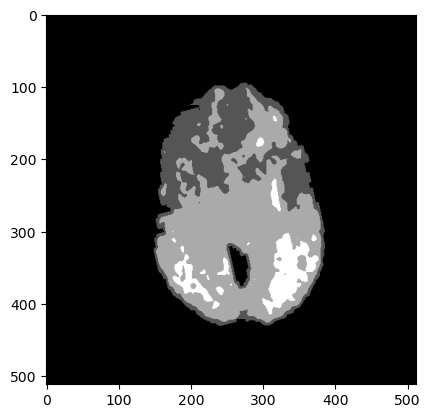

In [7]:
plt.imshow(sitk.GetArrayFromImage(sitk.ReadImage(r"D:\CTH_archive\TMAX_NIFTI\Reg_Quant\ALFORD_BARBARA.nii"))[10,:,:], cmap='gray')

# Load the .nii file
img = sitk.ReadImage(r"D:\CTH_Archive\TMAX_NIFTI\Reg_Quant\ALFORD_BARBARA.nii")

# Convert the image to a numpy array
data = sitk.GetArrayFromImage(img)

# Count the number of unique intensity levels
num_levels = len(np.unique(data))

print(f"The image has {num_levels} unique intensity levels.")
print(f"The intensity levels are: {np.unique(data)}")

In [17]:
def register_images(fixed_image_path, moving_image_path, transforms_dir):
    # Extract patient identifier from the file name
    patient = os.path.splitext(os.path.basename(moving_image_path))[0]

    # Load the fixed and moving images
    fixed_image = sitk.ReadImage(fixed_image_path)
    moving_image = sitk.ReadImage(moving_image_path)

    # Initialize the registration method
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingPercentage(0.6, sitk.sitkWallClock)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetOptimizerAsGradientDescentLineSearch(learningRate=0.5, numberOfIterations=300, convergenceMinimumValue=1e-6, convergenceWindowSize=20)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[8, 4, 2])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4, 2, 1])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Initialize the transform with a better starting point for images with minimal initial overlap
    initial_transform = sitk.CenteredTransformInitializer(sitk.Cast(fixed_image, moving_image.GetPixelID()), 
                                                          moving_image, 
                                                          sitk.AffineTransform(fixed_image.GetDimension()),
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)
    registration_method.SetInitialTransform(initial_transform, True)

    try:
        # Execute the registration
        final_transform = registration_method.Execute(fixed_image, moving_image)
        
        # Resample the moving image
        resampled_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

        # Save the transform and resampled image
        transform_file = os.path.join(transforms_dir, f'{patient}.h5')
        sitk.WriteTransform(final_transform, transform_file)
        
        print(f"Registration successful for patient: {patient}. Transform saved to {transform_file}")
    except RuntimeError as e:
        print(f"Registration failed for patient {patient}: {e}")

fixed_images_dir = "D:/CTH_archive/CTH_STRIPPED"
moving_images_dir = "D:/CTH_archive/CTP_STRIPPED"
transforms_dir = "D:/CTH_archive/Transforms_STRIPPED"

if not os.path.exists(transforms_dir):
    os.makedirs(transforms_dir)

for filename in os.listdir(fixed_images_dir):
    fixed_image_path = os.path.join(fixed_images_dir, filename)
    moving_image_path = os.path.join(moving_images_dir, filename)

    if os.path.isfile(fixed_image_path) and os.path.isfile(moving_image_path):
        register_images(fixed_image_path, moving_image_path, transforms_dir)
    

Registration successful for patient: ALFORD_BARBARA. Transform saved to D:/CTH_archive/Transforms_STRIPPED\ALFORD_BARBARA.h5


In [18]:
def resample_image(moving_image, fixed_image, ctp_image):
    desired_size = [fixed_image.GetSize()[0], fixed_image.GetSize()[1], ctp_image.GetSize()[2]]
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(moving_image)
    resampler.SetSize(desired_size)
    resampler.SetOutputSpacing([moving_image.GetSpacing()[i] * (moving_image.GetSize()[i] / desired_size[i]) for i in range(3)])
    resampler.SetTransform(sitk.Transform())
    resampler.SetInterpolator(sitk.sitkLinear)
    resized_moving_image = resampler.Execute(moving_image)
    resized_moving_image.SetSpacing(ctp_image.GetSpacing())
    resized_moving_image.SetOrigin(ctp_image.GetOrigin())
    resized_moving_image.SetDirection(ctp_image.GetDirection())
    return resized_moving_image

def apply_final_transform(resized_moving_image, fixed_image, transform_file_path):
    final_transform = sitk.ReadTransform(transform_file_path)
    resampled_image = sitk.Resample(resized_moving_image, 
                                    fixed_image, 
                                    final_transform, 
                                    sitk.sitkLinear, 
                                    0.0, 
                                    fixed_image.GetPixelID())
    return resampled_image

# Directories
tmax_nifti_dir = "D:/CTH_archive/TMAX_NIFTI_QUANT"
transforms_dir = "D:/CTH_archive/Transforms_STRIPPED"
cth_stripped_dir = "D:/CTH_archive/CTH_STRIPPED"
ctp_stripped_dir = "D:/CTH_archive/CTP_STRIPPED"
output_dir = os.path.join(tmax_nifti_dir, "Reg")

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterate over the transformation files
for transform_file in os.listdir(transforms_dir):
    transform_path = os.path.join(transforms_dir, transform_file)
    base_filename = transform_file.replace('.h5', '')

    # Paths to the moving, fixed, and reference (ctp) images
    moving_image_path = os.path.join(tmax_nifti_dir, base_filename + '.nii')
    fixed_image_path = os.path.join(cth_stripped_dir, base_filename + '.nii')
    ctp_image_path = os.path.join(ctp_stripped_dir, base_filename + '.nii')

    # Check if all required files exist
    if os.path.exists(moving_image_path) and os.path.exists(fixed_image_path) and os.path.exists(ctp_image_path):
        # Load images
        moving_image = sitk.ReadImage(moving_image_path)
        fixed_image = sitk.ReadImage(fixed_image_path)
        ctp_image = sitk.ReadImage(ctp_image_path)

        # Resample the moving image
        resized_moving_image = resample_image(moving_image, fixed_image, ctp_image)

        # Apply the final transformation
        resampled_image = apply_final_transform(resized_moving_image, fixed_image, transform_path)

        # Save the resampled image
        resampled_image_path = os.path.join(output_dir, base_filename + '.nii')
        sitk.WriteImage(resampled_image, resampled_image_path)
        print(f"Processed and saved: {resampled_image_path}")
    else:
        print(f"Required files for {base_filename} are not available.")
    

Processed and saved: D:/CTH_archive/TMAX_NIFTI_QUANT\Reg\ALFORD_BARBARA.nii


In [25]:
import os
import nibabel as nib

def convert_and_copy_with_labels_and_rename(image_source_dir, image_target_dir, label_source_dir, label_target_dir):
    # Ensure the target directories exist, create if they don't
    if not os.path.exists(image_target_dir):
        os.makedirs(image_target_dir)
    if not os.path.exists(label_target_dir):
        os.makedirs(label_target_dir)

    # Initialize a counter
    counter = 1

    # Iterate over all files in the image source directory
    for file_name in sorted(os.listdir(image_source_dir)):
        # Check if the file is a .nii file
        if file_name.endswith('.nii'):
            # Construct full source file paths for images and labels
            image_source_file_path = os.path.join(image_source_dir, file_name)
            label_source_file_path = os.path.join(label_source_dir, file_name)

            # Check if the corresponding label exists
            if not os.path.isfile(label_source_file_path):
                print(f"No corresponding label found for {file_name}, skipping...")
                continue  # Skip this file and move to the next one

            # Load the .nii file (image)
            nii_image = nib.load(image_source_file_path)

            # Construct the new file name for images and labels
            base_name = file_name[:-4]  # Remove .nii extension
            new_image_name = f"{base_name}_{counter:03d}_0000.nii.gz"
            new_label_name = f"{base_name}_{counter:03d}.nii.gz"

            # Construct target file paths
            image_target_file_path = os.path.join(image_target_dir, new_image_name)
            label_target_file_path = os.path.join(label_target_dir, new_label_name)

            # Save the image file as .nii.gz in the target directory
            nib.save(nii_image, image_target_file_path)
            print(f"Converted and copied image: {image_source_file_path} to {image_target_file_path}")

            # Load the .nii file (label)
            nii_label = nib.load(label_source_file_path)

            # Save the label file as .nii.gz in the target directory
            nib.save(nii_label, label_target_file_path)
            print(f"Converted and copied label: {label_source_file_path} to {label_target_file_path}")

            # Increment the counter
            counter += 1

# Define source and target directories for images and labels
image_source_dir = r"D:/CTH_archive/CTH_STRIPPED"
image_target_dir = r"D:/nnUNet_raw/Dataset037_Perfusion/imagesTr"
label_source_dir = r"D:/CTH_archive/TMAX_NIFTI_QUANT/Reg"
label_target_dir = r"D:/nnUNet_raw/Dataset037_Perfusion/labelsTr"

# Call the function
convert_and_copy_with_labels_and_rename(image_source_dir, image_target_dir, label_source_dir, label_target_dir)


Converted and copied image: D:/CTH_archive/CTH_STRIPPED\ALFORD_BARBARA.nii to D:/nnUNet_raw/Dataset037_Perfusion/imagesTr\ALFORD_BARBARA_001_0000.nii.gz
Converted and copied label: D:/CTH_archive/TMAX_NIFTI_QUANT/Reg\ALFORD_BARBARA.nii to D:/nnUNet_raw/Dataset037_Perfusion/labelsTr\ALFORD_BARBARA_001.nii.gz
Converted and copied image: D:/CTH_archive/CTH_STRIPPED\ALLAH_MAJUSTICE.nii to D:/nnUNet_raw/Dataset037_Perfusion/imagesTr\ALLAH_MAJUSTICE_002_0000.nii.gz
Converted and copied label: D:/CTH_archive/TMAX_NIFTI_QUANT/Reg\ALLAH_MAJUSTICE.nii to D:/nnUNet_raw/Dataset037_Perfusion/labelsTr\ALLAH_MAJUSTICE_002.nii.gz
Converted and copied image: D:/CTH_archive/CTH_STRIPPED\BATTLE_MARIA.nii to D:/nnUNet_raw/Dataset037_Perfusion/imagesTr\BATTLE_MARIA_003_0000.nii.gz
Converted and copied label: D:/CTH_archive/TMAX_NIFTI_QUANT/Reg\BATTLE_MARIA.nii to D:/nnUNet_raw/Dataset037_Perfusion/labelsTr\BATTLE_MARIA_003.nii.gz
Converted and copied image: D:/CTH_archive/CTH_STRIPPED\BOGER_DAVID_S.nii to 

In [26]:
import os
import json

def generate_dataset_json(dataset_dir, num_quant_levels, channel_names, nnUNet_dir, file_ending=".nii.gz", test_ratio=0.0):
    """
    Generate a dataset.json file for the given dataset with dynamic quantization levels.

    Args:
    - dataset_dir (str): Directory where the dataset files are stored.
    - num_quant_levels (int): Number of quantization levels (excluding the background).
    - channel_names (dict): Mapping of channel indices to their names.
    - file_ending (str): File extension of the dataset files.
    - test_ratio (float): Proportion of the dataset to be used for testing (between 0 and 1).

    Returns:
    - None
    """
    # Dynamically generate labels based on the number of quantization levels
    labels = {"background": "0"}
    for i in range(1, num_quant_levels + 1):
        labels[f"quantized_{i}"] = str(i)

    # Count the number of dataset files
    num_files = len([file for file in os.listdir(dataset_dir)])

    # Calculate the number of training and testing files based on the test_ratio
    num_test = int(num_files * test_ratio)
    num_training = num_files - num_test

    # Construct the dataset JSON structure
    dataset_json = {
        "labels": labels,
        "numTraining": num_training,
        "numTest": num_test,
        "channel_names": channel_names,
        "file_ending": file_ending
    }

    # Write the JSON structure to a file
    with open(os.path.join(nnUNet_dir, "dataset.json"), 'w') as json_file:
        json.dump(dataset_json, json_file, indent=4)

    print(f"dataset.json file has been generated in {nnUNet_dir}")

# Example usage
dataset_dir = r'D:\nnUNet_raw\Dataset037_Perfusion\labelsTr'  # Path to dataset directory
nnUNet_dir = r'D:\nnUNet_raw\Dataset037_Perfusion'  # Path to nnUNet directory
num_quant_levels = 5  # Number of quantization levels (excluding background)
channel_names = {"0": "CT"}

generate_dataset_json(dataset_dir, num_quant_levels, channel_names, nnUNet_dir, file_ending=".nii.gz", test_ratio=0.0)

dataset.json file has been generated in D:\nnUNet_raw\Dataset037_Perfusion
